This notebook was prepared by:

Jack Brennen (jpb9088@nyu.edu)

Fabrizio Cabrera (fc2250@nyu.edu)

Alex Ferrante (af3913@nyu.edu)

Graduate School of Arts and Sciences (GSAS) at New York University (NYU)

May 2022

# One Day Ahead Movement Stock Prediction - Application of Machine Learning Binary Classifiers  

In the stock market shares of firms are traded. Trading is an important feature of the economy because it gives firms access to capital in exchange for a share of ownership. Speculation in stock prices means that traders buy when they think prices are going up and sell when they think prices are going down. This would be profitable for traders making accurate predictions of stock prices. However, the predictability of stock prices has been questioned.

According to the efficient market hypothesis (EMH) the stock market follows a random walk and is inherently unpredictable (Sargent, 1986). The EMH implies that all information available today is reflected in prices of stocks today and the changes in tomorrows price will only depend on the news of tomorrow. This is because that the stock market is perceived to be very informationally efficient and comopetitive. Since we cannot predict news, stock forecasting is impossible. This would have the consequence that prices are fairly priced and one can not beat the market using current information. Burton Malkiel claims that a strong argument for the market being efficient and unpredictable is that fact that expert investors are unable to beat the market (Malkiel, 2003).

The ability to predict the movement of a stock was once far fetched, however, thanks to advancements in machine learning techniques, there is reason to believe short-run predictions are possible, within reason. So what makes stock movement prediction tricky? Well, several factors, but one which is most obscure is market noise. With most persons' having access to the internet, news spreads quickly. This means consumers' sentiments are subject to changing quickly, resulting in short-run market fluctuations. Exogenous shocks to the market come in many forms and all of which are reported on. With the rise of internet news platforms these sources server as venues for market particpants to consume stock information which subsequetly informs short-run behavior. 

Since we believe that capturing trends in agents news consumption is valuable in explaining short-run movements in stocks, this project will include data from Google Trends and Wikipedia API's to serve as indexes to inform the frequency and popularity of stock news. In addition to data collected from Google Trends and Wikipedia API's we also collect general stock data (open, close, volumem ect.). Through the use of random forrests, convolutional neural networks (CNN), and recursive neural networks (RNN) we will contruct a binary-classification task and see how accurately we can model short-run stock movement. While there are an array of targets we could test, the target for the procedding models will be whether the stock closing price will increase tomorrow (1) or whether it will decrease (0). 

Given constraints in time and computing power, we will collect data from 01/01/2019 to 03/31/2022 for Ford, Netflix, and UBS. The stocks selected cover three different industires which will allow us to tests our models preictive power in varying markets.   


## 1. Pulling Together the Data

As the saying goes, garbage in, garbage out. Thus, we gave some serious thought on how to best collect our data. This section reviews the necessary steps taken to aquire the stock and news data from their respective API's and the subsequent data cleaning procedures. Given that the web scraping process was computationally expensive, this section will display the code in its raw form. At the end of section two the cleaned and transformed CSV data files will be made available. Your computer will thank us later.

In [2]:
# Import the necessary data cleaning packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

#%pip install pytrends
import pytrends
from pytrends.request import TrendReq
#%pip install pageviewapi
import pageviewapi
#%pip install yfinance
import yfinance as yf

# Import machine learning packages
import tensorflow as tf
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection
)
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN, LSTM, TimeDistributed, BatchNormalization, Conv1D, MaxPooling1D, Flatten, InputLayer
from sklearn.model_selection import TimeSeriesSplit
from keras.regularizers import l1, l2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier

### 2. Data Processing - Feature and Target Creation

In this next phase of data processing we focus on using the existing data pulled to generate additional features and targets. From the Google News and Wikipedia data collected, we sum across each of the keyword list results to create two new features noted as "Wiki_total" and "Google_total", respectively. These new "total" features will then be used as denominator values and assist in creating more features which with the hope of providing greater explanantory power to our future models.   

Now that we have a comprehesive feature matrix of data, we turn to generating the targets. As mentioned, there are a variety of targets that could be tested to predict stock movement. Below we have generated five binary targets, each either related to the stock close price, open price, or volumne. For the purposes of the models developed in this project, we will focus on trying to accurately predict "target_3" - the difference in closing price. This target's result is binary where an increase in the closing price returns a value of 1 and a decrease in the closing price returns 0.

Finally, we've made it to a stage where out data set includes many features and targets to test them on. 

Below are the fully cleaned and model ready CSV files for Ford, Netflix, and UBS.

In [3]:
ubs = pd.read_csv("UBS_Cleaned_Date.csv",
                 parse_dates=True,
                 infer_datetime_format=True,
                 index_col="date")
ubs
        

,UBS_x,UBS Financial Services Inc.,UBS Investment Bank,UBS Global Wealth Management,UBS Asset Management,Open,High,Low,Close,Volume,...,Dow_EMA_Move,Dow_EMA_Move_5,Dow_Disparity_Move,Dow_Disparity_s_Move,Dow_RSI_Move,target_1,target_2,target_3,target_4,target_5
date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,6.708333,0.0,0.0,0.0,0.000000,10.378242,10.700180,10.282508,10.632403,3210100.0,...,0,0,0,0,0,0,1,0,1,0
2019-01-03,5.708333,0.0,0.0,0.0,0.000000,10.522266,10.606987,10.465503,10.496850,2534700.0,...,0,0,0,0,0,1,1,1,1,1
2019-01-04,14.791667,0.0,0.0,0.0,0.000000,10.734068,10.937397,10.687472,10.878093,2743500.0,...,1,1,1,1,0,0,1,1,1,1
2019-01-07,12.208333,0.0,0.0,0.0,0.000000,10.878092,11.056005,10.823024,10.988229,3163300.0,...,1,1,1,0,0,1,1,1,1,0
2019-01-08,2.333333,0.0,0.0,0.0,0.000000,11.047532,11.089893,10.945868,11.013644,2384500.0,...,1,1,0,1,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-24,0.000000,0.0,0.0,0.0,0.000000,18.512881,18.600435,18.425326,18.580978,2722700.0,...,1,1,1,1,0,1,1,1,1,1
2022-03-25,11.208333,0.0,0.0,0.0,0.000000,18.629619,18.824185,18.600436,18.814457,3241500.0,...,1,1,1,1,0,1,1,0,1,1
2022-03-28,10.958333,0.0,0.0,0.0,2.791667,18.843641,18.863096,18.437971,18.678261,3579600.0,...,1,1,0,0,0,1,1,1,1,0


### 3. Feature Selection 

Now that we have the data cleaned, additional features created, and targets set, we can begin to think about constucting our models. However, before jumping into deciding which model to use and the appropriate architecture for this time-series, binary classfication task, we must first give some thought to what features are going to give our models the greatest preictive power.

Taking a look first at the shape of our data, we notice that there are quite a few features present.

With 169 features in total, it is likely the case that not all variable are valuable in predicting our target. A generic, although not often recommended approach would be the kitchen sink, where all 169 features would be included in our models. While this would be simple, if we work under the assumption that some variables are not relevant in explaining our target, then this approach would negatively affect our models ability to learn since we would be introducing unnecessary noise. While there are many approaches to feature selection, we decide on the implement the following strategies:

1) SelectKBest

2) Principal Component Analysis

3) Blended - Identify the "best features" through SelectKBest, then run a PCA on those features

From the Keras "feature_selection" library, the SelectKBest function works by implementing an f-regression to identify the N number of features that have the greatest significance in explaining the identified target.  

Let's continue with using ubs as an example and see how these feature selection methodologies are implemented.

We'll first do a little more data manipulation.

In [4]:
# SelectKBest implementation

# to remove first 14 days that include NaNs due to some calculations
ubs = ubs.iloc[14:, :] 

# to remove duplicated columns
ubs = ubs.drop(["Nas_total", 'Stock_total', 'Dow_total'],axis=1) 

ubs = ubs.dropna()
ubs = ubs[~(ubs.isin([np.inf, -np.inf]).any(axis=1))] 

# Drop additional targets
ubs = ubs.drop(['target_1', 'target_2', 'target_4', 'target_5'], axis=1)

# Target will be 3 (close to close)
target_3_0 = ubs["target_3"]

# Print shape 
print(ubs.shape, target_3_0.shape)

# Standardize the data 
Mscaler = MinMaxScaler()
ubs = pd.DataFrame(Mscaler.fit_transform(ubs), columns = ubs.columns)

# Implement SelectKBest class to extract 40 best features
bestfeatures = SelectKBest(score_func=f_regression, k=40)
best_fit = bestfeatures.fit(ubs, target_3_0)
best_scores = pd.DataFrame(best_fit.scores_)
best_columns = pd.DataFrame(ubs.columns)

# concatenate the dataframes for better visualization
features_score = pd.concat([best_columns, best_scores], axis=1)
features_score.columns = ['Features', 'Score'] 
print(features_score.nlargest(40, 'Score'))  


(748, 193) (748,)
                   Features       Score
53             Change_Close  644.858265
151                Nas_Move    5.663528
158    Nas_Disparity_s_Move    4.196393
154            Nas_ROC_Move    3.085478
157      Nas_Disparity_Move    2.888064
145                Nas_gain    2.842672
54            Change_Google    2.800310
56           Wiki_MAvg_Move    2.746782
190    Dow_Disparity_s_Move    2.622576
48            Wiki_avg_loss    2.267743
66        Google_Moment_1_s    2.209778
76             Google_ROC_s    2.209778
46                Wiki_loss    1.974624
67        Google_Moment_2_s    1.946196
2       UBS Investment Bank    1.927082
63            Wiki_RSI_Move    1.800070
42                 Wiki_EMA    1.768842
189      Dow_Disparity_Move    1.764803
37         Wiki_Disparity_s    1.621962
183                Dow_Move    1.621437
15   Banking in Switzerland    1.589168
173                Dow_Rocp    1.551794
81              Google_gain    1.502137
91          Google_EMA

/Users/fabrizio/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Shown above the top 40 features (descending order) that have the greatest significance with respect to target 3. This list can now give us greater insight into which features should be included in model testing and which should be dropped.

Alternatively, we could use a PCA approach to reduce the dimenstionality of the data without having to necessarily hand pick features. Let's see this in action.

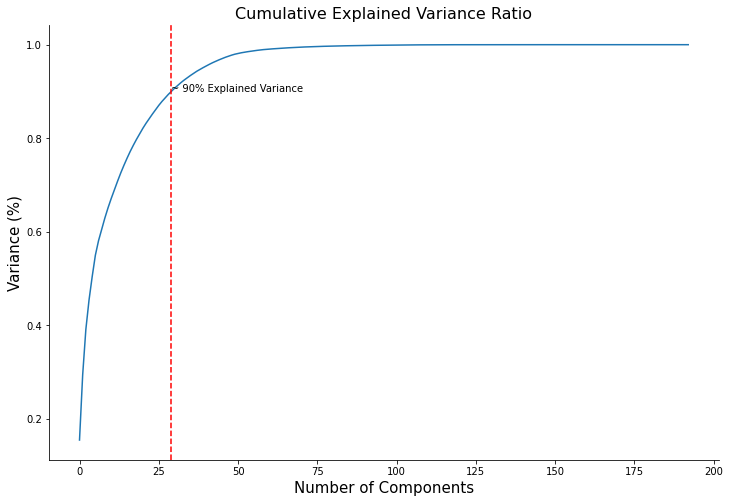

[ 15.48793912  29.44338815  39.12797976  45.40722235  50.42460193
  54.99116512  58.10087474  60.55540511  62.95708243  65.13580777
  67.11681566  68.98075668  70.81003622  72.5707573   74.19808488
  75.73909839  77.1939763   78.53163767  79.79516783  80.99210592
  82.14927451  83.21711912  84.21151984  85.17471581  86.11853706
  87.02577956  87.85945036  88.62716797  89.36133593  90.05202516
  90.71000392  91.31445842  91.89435605  92.43565167  92.93125774
  93.42113785  93.88363755  94.32506641  94.71678571  95.09932093
  95.46341314  95.81943386  96.1569861   96.46656655  96.76128843
  97.041931    97.30480146  97.54499745  97.7695605   97.96722565
  98.12161222  98.26638841  98.38865616  98.49784541  98.60230962
  98.6997221   98.78838569  98.87532102  98.94683237  99.00888925
  99.06273866  99.11357066  99.16238604  99.21015868  99.2554723
  99.29940476  99.33959752  99.37703448  99.41386646  99.44758292
  99.47924483  99.51052715  99.53817492  99.56540853  99.58914078
  99.612139

In [5]:
# PCA implementation
pca = PCA().fit(ubs)
fig, ax = plt.subplots(figsize=(12,8))

# Display cumulated explained variance ratio
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative Explained Variance Ratio', fontsize=16)
plt.xlabel('Number of Components', fontsize=(15))
plt.ylabel('Variance (%)', fontsize=(15)) 

annotation = 29
plt.axvline(annotation, color='r', linestyle='--')
plt.annotate('~ 90% Explained Variance', xy=(annotation, 0.8), xytext=(annotation, 0.9))

ax.spines[['top', 'right']].set_visible(False)

plt.show()

print(np.cumsum(pca.explained_variance_ratio_) * 100) 


From the graph depicted above, we can apply a PCA decomposition on our origional feature data and with using only 29 principal components explain approximately ~90% of the variance of our target.

In the third and final approach mentioned, we look to blend the two feature selection strategies by running a PCA decomposition, but only on the N best features found using SelectKbest. The rationale behind this blended strategy is that if we look at the bottom half of the SelectKBest results (presented above), we notice that many of the features are marginally significant in explaining the target. It could be the case that including features which have little explanitory power is causing more harm than good. Mainly, thier inclusion could introduce more noise than predicitve power. Thus, by only selecting features which have a relitively stronger and significant relationship to the target we can have greater confidence that we are mitigating the inculsion of noisy features.

In [6]:
# Apply SelectKBest class to extract top 40 best features
bestfeatures = SelectKBest(score_func=f_regression, k=41)
best_fit = bestfeatures.fit(ubs, target_3_0)
best_scores = pd.DataFrame(best_fit.scores_)
best_columns = pd.DataFrame(ubs.columns)

# Concatenate the dataframes for better visualization
features_score = pd.concat([best_columns, best_scores], axis=1)
features_score.columns = ['Features', 'Score'] 
feats_kb = list(features_score.nlargest(41, 'Score').iloc[1:41]['Features'])

# Keep only the top 40 features
ubs_best = ubs[feats_kb]

/Users/fabrizio/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


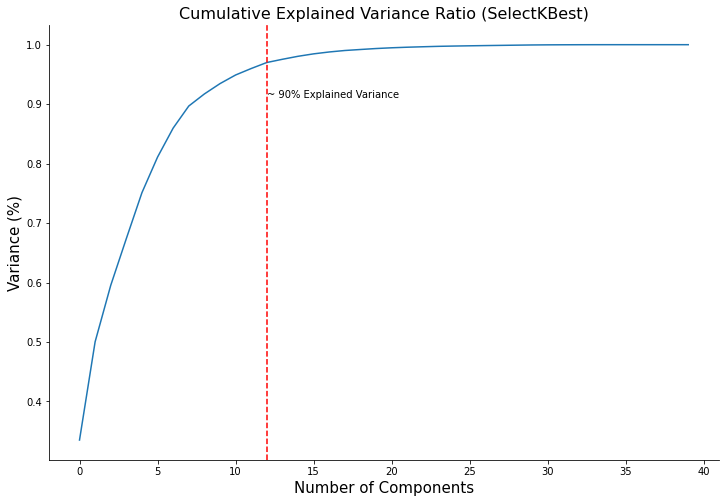

[ 33.51149115  50.0348824   59.5235872   67.3942708   75.11400421
  81.09492316  85.97501452  89.68315279  91.71477696  93.4513084
  94.90378793  95.99270191  97.00244505  97.54536958  98.04777333
  98.45872429  98.7745254   99.0225303   99.19154854  99.35343167
  99.47916682  99.57496683  99.65143551  99.72282904  99.77100401
  99.81195425  99.84998503  99.88516783  99.91985321  99.95318949
  99.97363948  99.985599    99.99329971  99.99854279 100.
 100.         100.         100.         100.         100.        ]


In [7]:
# PCA implementation
pca = PCA().fit(ubs_best)
fig, ax = plt.subplots(figsize=(12,8))

# Display cumulated explained variance ratio
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative Explained Variance Ratio (SelectKBest)', fontsize=16)
plt.xlabel('Number of Components', fontsize=(15))
plt.ylabel('Variance (%)', fontsize=(15)) 

annotation = 12
plt.axvline(annotation, color='r', linestyle='--')
plt.annotate('~ 90% Explained Variance', xy=(annotation, 0.8), xytext=(annotation, 0.91))

ax.spines[['top', 'right']].set_visible(False)

plt.show()

print(np.cumsum(pca.explained_variance_ratio_) * 100) 

When using a PCA transform on the features found from SelectKBest, it is possible to explain ~90% of the variance with far fewer principal components. 

### 4. Model Development and Testing

In the previous section we reviewed a few of the possible feature selection techniques used by machine learning practitioners. In this section we will dive into model development and testing, where we begin to see the fruits of our computers labor. One thing to note is that each of the three algorthms presented (Random Forest, CNN'S, and RNN's) were tested using each of the feature selection methodologies. We felt that this approach would allow us to be comprehesive in finding optimal results, while also added an experimetnal element to model development. That being said, trialing feature selection approaches resulted in many models being created. In an effort to reduce unnecesary confusion, we will only present the models which generated the best results and the processes undertaken to arrive at them. Additionally, the following section will only present the code used in the development of ubs models. Results for Netlifx and UBS will be presented, however, for brevity the code will not be included. Additional code can be found on the project GitHub repository (https://github.com/fabcabrera/Stock-Predictions). 

### 4.1 Random Forest

Random forest uses several decision trees and takes the mean output of all the trees as the result. Each tree is trained randomly on a subset of the input data. Doing this removes the issue of over-training and allows for more features for a smaller performance cost (Kam Ho, 1995). 
Decision trees are flowcharts that depict outcome probabilities depending on given variables. The problem of creating such trees optimally is nondeterministic-polynomial-time complete (Hyafil, 1976) but approximate methods do exist. For example, induction of decision is a common method. With this method the set of input is divided based on some output value being above a threshold that is random. Then an input variable is chosen and a threshold set so that as many values are classified correctly as possible. This process continues recursively until all the data is classified in a correct way, or no improvement can be made (Ross Quinlan, 1986).

The following code will work through the steps taken to build our random forest. 

In [8]:
# Drop NaNs
ubs = ubs.dropna()
ubs = ubs[~(ubs.isin([np.inf, -np.inf]).any(axis=1))] 

# Generate target vector and feature matirx 
target_3 = ubs["target_3"]

# Split into training and testing sets 
column_indices = {name: i for i, name in enumerate(ubs.columns)}

n = len(ubs)

X_train = ubs[0:int(n*0.9)]
X_test = ubs[int(n*0.9):]

y_train = target_3[0:int(n*0.9)]
y_test = target_3[int(n*0.9):]

In [9]:
# Print distirbution of target variable
counts = y_train.groupby(by = y_train).count()
counts = pd.Series(counts)
print(counts)

target_3
0.0    330
1.0    343
Name: target_3, dtype: int64


In [10]:
# Standardize the data
Mscaler = MinMaxScaler() 

X_train = pd.DataFrame(Mscaler.fit_transform(X_train), columns = ubs.columns)
X_test = pd.DataFrame(Mscaler.fit_transform(X_test), columns = ubs.columns)

In [11]:
# Apply SelectKBest class to extract top 40 best features
bestfeatures = SelectKBest(score_func=f_regression, k=41)
best_fit = bestfeatures.fit(X_train, y_train)
best_scores = pd.DataFrame(best_fit.scores_)
best_columns = pd.DataFrame(ubs.columns)

# Concatenate the dataframes for better visualization
features_score = pd.concat([best_columns, best_scores], axis=1)
features_score.columns = ['Features', 'Score'] 
feats_kb = list(features_score.nlargest(41, 'Score').iloc[1:41]['Features'])

# Set SelectKBest to train and test data
X_train_kb = X_train[feats_kb]
X_test_kb = X_test[feats_kb]

# Apply PCA to the training and testing data
pca_kb = PCA(n_components = 12).fit(X_train_kb.to_numpy())
X_train_kb = pca_kb.transform(X_train_kb.to_numpy())
X_test_kb = pca_kb.transform(X_test_kb.to_numpy())

/Users/fabrizio/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [12]:
# Build Random Forest classifier
random_search = {'criterion': ['entropy', 'gini'],
               'max_depth': list(np.linspace(10, 1200, 10, dtype = int)) + [None],
               'max_features': ['auto', 'sqrt','log2', None],
               'min_samples_leaf': [4, 6, 8, 12],
               'min_samples_split': [5, 7, 10, 14],
               'n_estimators': list(np.linspace(10, 1200, 15, dtype = int))}

clf = RandomForestClassifier()
model_kb = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 100, 
                               cv = 10, verbose= 5, random_state= 101, n_jobs = -1)
                
model_kb.fit(X_train_kb,y_train)

model_kb.best_params_

y_kb_hat = model_kb.best_estimator_.predict(X_test_kb)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [ ]:
print("Random Forest Accuracy with SelectKBest features: {}%".format(accuracy_score(y_test, y_kb_hat).round(4)*100))

Random Forest Accuracy with SelectKBest features: 41.33%


Using the SelectKBest to determine the 40 most significant features, our random forest model returns an accuracy score or 57%. With the basic model structure down, we can next begin to test various hyperparamters in hopes of improvinf the models predictive accuracy.

In [ ]:
def kbest_creator(k, df, df_test):
    """
    Returns list of k best features and the number of efficient principle components to use with said k features
    """
    # Apply SelectKBest class to extract top 40 best features
    bestfeatures = SelectKBest(score_func=f_regression, k=k)
    best_fit = bestfeatures.fit(df, y_train)
    best_scores = pd.DataFrame(best_fit.scores_)
    best_columns = pd.DataFrame(ubs.columns)
    
    # Concatenate the dataframes for better visualization
    features_score = pd.concat([best_columns, best_scores], axis=1)
    features_score.columns = ['Features', 'Score']  # naming the dataframe columns
    feats_kb = list(features_score.nlargest(k, 'Score').iloc[1:k]['Features'])

    # Run PCA decomposition on the K best features
    pca = PCA().fit(df[feats_kb])
    pca_scores = np.cumsum(pca.explained_variance_ratio_) * 100
    res = next(x for x, val in enumerate(pca_scores) if val > 85)
    res = res + 1
    res
    
    pca_kb_1 = PCA(n_components = res).fit(df[feats_kb].to_numpy())
    df = pca_kb_1.transform(df[feats_kb].to_numpy())
    df_test = pca_kb_1.transform(df_test[feats_kb].to_numpy())
    
    return df, df_test

In [ ]:
# Create train and test data with varying number of K best features
X_train_kb_1, X_test_kb_1, = kbest_creator(11, X_train, X_test)
X_train_kb_2, X_test_kb_2, = kbest_creator(26, X_train, X_test)
X_train_kb_3, X_test_kb_3, = kbest_creator(76, X_train, X_test)

/Users/fabrizio/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/fabrizio/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/fabrizio/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [ ]:
# Test using 11 K best features
random_search = {'criterion': ['entropy', 'gini'],
               'max_depth': list(np.linspace(10, 1200, 10, dtype = int)) + [None],
               'max_features': ['auto', 'sqrt','log2', None],
               'min_samples_leaf': [4, 6, 8, 12],
               'min_samples_split': [5, 7, 10, 14],
               'n_estimators': list(np.linspace(10, 1200, 15, dtype = int))}
clf = RandomForestClassifier()
model1 = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 100, 
                               cv = 10, verbose= 5, random_state= 101, n_jobs = -1)
model_kb1 = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 100, 
                               cv = 10, verbose= 5, random_state= 101, n_jobs = -1)

model_kb1.fit(X_train_kb_1,y_train)

y_kb_hat_1 = model_kb1.best_estimator_.predict(X_test_kb_1)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [ ]:
# Test using 26 K best features
model_kb2 = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 100, 
                               cv = 10, verbose= 5, random_state= 101, n_jobs = -1)
model_kb2.fit(X_train_kb_2,y_train)

y_kb_hat_2 = model_kb2.best_estimator_.predict(X_test_kb_2)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [ ]:
# Test using 76 K best features
model_kb3 = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 100, 
                               cv = 10, verbose= 5, random_state= 101, n_jobs = -1)
model_kb3.fit(X_train_kb_3,y_train)

y_kb_hat_3 = model_kb3.best_estimator_.predict(X_test_kb_3)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [ ]:
print("Random Forest Accuracy with 11 SelectKBest features: {}%".format(accuracy_score(y_test, y_kb_hat_1).round(4)*100))
print("Random Forest Accuracy with 26 SelectKBest features: {}%".format(accuracy_score(y_test, y_kb_hat_2).round(4)*100))
print("Random Forest Accuracy with 76 SelectKBest features: {}%".format(accuracy_score(y_test, y_kb_hat_3).round(4)*100))

Random Forest Accuracy with 11 SelectKBest features: 66.67%
Random Forest Accuracy with 26 SelectKBest features: 48.0%
Random Forest Accuracy with 76 SelectKBest features: 46.67%


While it may not be much, after a little hyperparamter tuning, we are able to increase our random forest models prediction accuracy to a modest 60%. What is interesting to note from the results is the 15% increase in the models accuracy when we go from including 11 to 26 features. However, the rate in which accuracy increases with the number of features included seems to be diminishing since the jump from 26 to 76 features leads to a decrease in model performance. This reaffirms the notion that including features with marginal explanatory power are harmful to model performance.     

Include results for Netflix and UBS here

#### 4.2 Convolutional Neural Network (CNN)

Provide description of CNN

In [ ]:
# Create train, validation and test data 
column_indices = {name: i for i, name in enumerate(ubs.columns)}

n = len(ubs)
X_train = ubs[0:int(n*0.7)]
X_val = ubs[int(n*0.7):int(n*0.9)]
X_test = ubs[int(n*0.9):]

y_train = target_3[0:int(n*0.7)]
y_val = target_3[int(n*0.7):int(n*0.9)]
y_test = target_3[int(n*0.9):]

In [ ]:
# Standardize the data using MinMaxScaler
X_train = pd.DataFrame(Mscaler.fit_transform(X_train), columns = ubs.columns)
X_val = pd.DataFrame(Mscaler.fit_transform(X_val), columns = ubs.columns)
X_test = pd.DataFrame(Mscaler.fit_transform(X_test), columns = ubs.columns)

In [ ]:
def df_to_X_y2(df, target, window_size=5):
    """
    Generates a a timeseries window to all for prediction of future values. 
    """
    # converts to matrix of numpy arrays  
    df_as_np = df.to_numpy() 

    X = []
    y = []

    # Length of data frame - window_size so it does't take empty values at the end
    for i in range(len(df_as_np)-window_size): 
    
        # Takes row i and all rows above within the window size length
        row = [r for r in df_as_np[i:i+window_size]] 

        # Creates 3 dimentional array (obseravtions, rows in window, features)
        X.append(row)

        # Pulls the target variable after the window, target varible needs to be column zero in this 
        label = target[i+window_size] 

        # returns (N,) martix of targets i+window_length time periods away
        y.append(label) 

    return np.array(X), np.array(y)

In [ ]:
def kbest_creator(k):
    """
    Returns list of k best features and the number of efficient principle compents to use with said k features.
    Differs from the kbest_creator function in the random forest section where the only paramter now
    is k.
    """
    # Apply SelectKBest class to extract top 40 best features
    bestfeatures = SelectKBest(score_func=f_regression, k=k)
    best_fit = bestfeatures.fit(X_train, y_train)
    best_scores = pd.DataFrame(best_fit.scores_)
    best_columns = pd.DataFrame(ubs.columns)
    
    # Concatenate the dataframes for better visualization
    features_score = pd.concat([best_columns, best_scores], axis=1)
    features_score.columns = ['Features', 'Score']  # naming the dataframe columns
    feats = list(features_score.nlargest(k, 'Score')['Features'])

    # Run PCA decomposition on the K best features
    pca = PCA().fit(X_train[feats])
    pca_scores = np.cumsum(pca.explained_variance_ratio_) * 100
    res = next(x for x, val in enumerate(pca_scores) if val > 85)
    res = res +1
    res
    
    return feats, res

In [ ]:
feats, comp = kbest_creator(5)

sklearn_pca = PCA(n_components=comp)
X_train_1 = pd.DataFrame(sklearn_pca.fit_transform(X_train[feats]))
X_val_1 = pd.DataFrame(sklearn_pca.transform(X_val[feats]))
X_test_1 = pd.DataFrame(sklearn_pca.transform(X_test[feats]))

# converting to window format, in this case 5 periods
X_train_1, train_5w = df_to_X_y2(X_train_1,y_train)
X_val_1, val_5w = df_to_X_y2(X_val_1, y_val)
X_test_1, test_5w = df_to_X_y2(X_test_1, y_test)

NameError: name 'kbest_creator' is not defined

In [ ]:
# Construct the CNN model
early_stopping_monitor = EarlyStopping(patience=7)

# Window and feature dimensions
n_steps = X_train_1.shape[1]
n_features = X_train_1.shape[2]

model1_2 = Sequential()
model1_2.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features))) 
model1_2.add(Conv1D(filters=15, kernel_size=2, activation='relu'))
# better without pooling layer
model1_2.add(Flatten())
model1_2.add(Dense(30, activation='relu')) 
model1_2.add(Dense(30, activation='relu')) 
model1_2.add(Dense(1, activation='sigmoid'))

model1_2.compile(optimizer='adam', 
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=["accuracy"])

model1_2_hist = model1_2.fit(X_train_1, train_5w,epochs=30,  
                            validation_data=(X_val_1, val_5w), 
                            callbacks = [early_stopping_monitor])

model1_2_hist


Epoch 1/30


C:\Users\alexa\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


16/16 [==============================] - 1s 10ms/step - loss: 0.6943 - accuracy: 0.5010 - val_loss: 0.6943 - val_accuracy: 0.5255
Epoch 2/30
16/16 [==============================] - 0s 3ms/step - loss: 0.6896 - accuracy: 0.5479 - val_loss: 0.6935 - val_accuracy: 0.5036
Epoch 3/30
16/16 [==============================] - 0s 3ms/step - loss: 0.6889 - accuracy: 0.5336 - val_loss: 0.6945 - val_accuracy: 0.5474
Epoch 4/30
16/16 [==============================] - 0s 4ms/step - loss: 0.6863 - accuracy: 0.5621 - val_loss: 0.6951 - val_accuracy: 0.4818
Epoch 5/30
16/16 [==============================] - 0s 3ms/step - loss: 0.6850 - accuracy: 0.5723 - val_loss: 0.6964 - val_accuracy: 0.4964
Epoch 6/30
16/16 [==============================] - 0s 3ms/step - loss: 0.6833 - accuracy: 0.5662 - val_loss: 0.6980 - val_accuracy: 0.5182
Epoch 7/30
16/16 [==============================] - 0s 3ms/step - loss: 0.6805 - accuracy: 0.5743 - val_loss: 0.7018 - val_accuracy: 0.4672
Epoch 8/30
16/16 [============

In [ ]:
model1_2_hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

CNN inital model accuracy: 54.55%


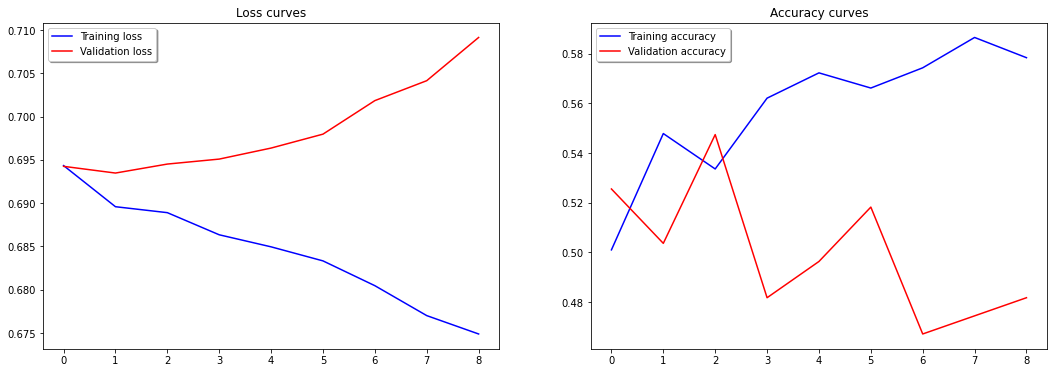

In [ ]:
# Predict on test data
y_hat1_2 = model1_2.predict(X_test_1)

# Find the accuracy of the model. Values greater than 0.5 are considered 1, else 0.
y_hat1_2 = y_hat1_2 > .5

print("CNN inital model accuracy: {}%".format(metrics.accuracy_score(test_5w,y_hat1_2).round(4)*100))

# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

axs[0].plot(model1_2_hist.history['loss'], color='b', label='Training loss')
axs[0].plot(model1_2_hist.history['val_loss'], color='r', label='Validation loss')

axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)

axs[1].plot(model1_2_hist.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(model1_2_hist.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)

plt.show()